# Spaceship Titanic: AutoGluon 최적화 모델

이 노트북은 `Spaceship_3_수정후.ipynb`의 피처 엔지니어링 과정을 복제하고, AutoGluon을 사용하여 최적의 모델을 찾는 것을 목표로 합니다.

## 주요 단계
1. 데이터 로드
2. 결측치 처리 및 파생 변수 생성 (기존 노트북 로직 계승)
3. 데이터 인코딩 및 스케일링
4. AutoGluon을 이용한 모델 학습 (`best_quality` 프리셋 적용)
5. 제출 파일 생성

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from autogluon.tabular import TabularPredictor

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 로드

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (8693, 14)
Test shape: (4277, 13)


## 2. 데이터 전처리 , 특성 엔지니어링

`Spaceship_3_수정후.ipynb`에서 수행한 전처리 과정을 동일하게 적용합니다.

In [3]:
# 처리를 위해 데이터 합치기
all_data = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

# 1. Group, GroupSize, FamilyId, FamilySize 생성
all_data['Group'] = all_data['PassengerId'].apply(lambda x: x.split('_')[0])
all_data['GroupSize'] = all_data.groupby('Group')['Group'].transform('count')

# 2. Cabin 분리 (Deck, Num, Side)
all_data[['Deck', 'Num', 'Side']] = all_data['Cabin'].str.split('/', expand=True)

# 3. Surname 생성
all_data['Surname'] = all_data['Name'].str.split().str[-1]

# 4. FamilyId, FamilySize 생성
all_data['FamilyId'] = all_data['Surname'] + all_data['Group']
all_data['FamilySize'] = all_data.groupby('FamilyId')['FamilyId'].transform('count')

### 결측치 처리

각 컬럼별로 논리적인 규칙을 적용하여 결측치를 채웁니다.

In [ ]:
# 지출 관련 컬럼
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# TotalSpending 결측치 처리 (0으로 채움)
all_data[spending_cols] = all_data[spending_cols].fillna(0)
all_data['TotalSpending'] = all_data[spending_cols].sum(axis=1)

# 2CryoSleep 결측치 처리
# 지출이 있으면 깨어 있음(False), 지출이 없으면 동면 중(True)일 확률 높음
all_data.loc[(all_data['CryoSleep'].isna()) & (all_data['TotalSpending'] > 0), 'CryoSleep'] = False
all_data.loc[(all_data['CryoSleep'].isna()) & (all_data['TotalSpending'] == 0), 'CryoSleep'] = True

# Age 결측치 처리 (중앙값)
age_median = all_data['Age'].median()
all_data['Age'] = all_data['Age'].fillna(age_median)

# AgeGroup 생성
def update_age_group(age):
    if age <= 4: return 'Baby'
    elif age <= 12: return 'Child'
    elif age <= 19: return 'Teenager'
    elif age <= 40: return 'Adult'
    elif age <= 60: return 'Middle Aged'
    else: return 'Senior'

all_data['AgeGroup'] = all_data['Age'].apply(update_age_group)

# VIP 결측치 처리
# 지출이 0원이거나 미성년자, 혹은 지구 출신이면 VIP가 아닐 확률이 높음
all_data.loc[(all_data['VIP'].isna()) & (all_data['TotalSpending'] == 0), 'VIP'] = False
all_data.loc[(all_data['VIP'].isna()) & (all_data['Age'] <= 19), 'VIP'] = False
all_data.loc[(all_data['VIP'].isna()) & (all_data['HomePlanet'] == 'Earth'), 'VIP'] = False
all_data['VIP'] = all_data['VIP'].fillna(False)

# Destination 결측치 처리 (최빈값)
dest_mode = all_data['Destination'].mode()[0]
all_data['Destination'] = all_data['Destination'].fillna(dest_mode)

# HomePlanet 결측치 처리
# 같은 그룹이나 성씨를 공유하는 승객의 정보를 활용
all_data['HomePlanet'] = all_data.groupby('Group')['HomePlanet'].ffill().bfill()
home_map = all_data.dropna(subset=['HomePlanet']).groupby('Surname')['HomePlanet'].apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
all_data['HomePlanet'] = all_data['HomePlanet'].fillna(all_data['Surname'].map(home_map))
all_data['HomePlanet'] = all_data['HomePlanet'].fillna(all_data['HomePlanet'].mode()[0])

# Cabin 결측치 처리
# 같은 그룹의 Deck, Side, Num 정보 공유
all_data['Deck'] = all_data.groupby('Group')['Deck'].ffill().bfill()
all_data['Side'] = all_data.groupby('Group')['Side'].ffill().bfill()
all_data['Num'] = pd.to_numeric(all_data['Num'], errors='coerce')
all_data['Num'] = all_data.groupby('Group')['Num'].ffill().bfill()

# 남은 결측치는 최빈값 또는 평균으로 채움 (AutoGluon은 결측치를 잘 처리하지만, 명시적 처리가 도움될 수 있음)
all_data['Deck'] = all_data['Deck'].fillna(all_data['Deck'].mode()[0])
all_data['Side'] = all_data['Side'].fillna(all_data['Side'].mode()[0])
all_data['Num'] = all_data['Num'].fillna(all_data['Num'].median())

### 파생 변수 생성 및 정리

모델 학습에 도움이 될 추가 변수를 생성하고, 불필요한 데이터를 정리합니다.

In [5]:
# 추가 파생 변수
all_data['IsSleepZero'] = (all_data['TotalSpending'] == 0).astype(int)
all_data['IsAlone'] = ((all_data['GroupSize'] == 1) & (all_data['FamilySize'] == 1)).astype(int)
all_data['IsVIPDeck'] = all_data['Deck'].isin(['B', 'C', 'T']).astype(int)

# Boolean 타입 정수형 변환
all_data['CryoSleep'] = all_data['CryoSleep'].astype(int)
all_data['VIP'] = all_data['VIP'].astype(int)

# 데이터 정제
# 동면 중인 승객의 지출액은 0원이어야 함 (논리적 오류 수정)
all_data.loc[all_data['CryoSleep'] == 1, spending_cols] = 0
all_data['TotalSpending'] = all_data[spending_cols].sum(axis=1)

# 불필요한 컬럼 삭제
drop_cols = ['PassengerId', 'Name', 'Cabin', 'Surname', 'Group', 'FamilyId', 'AgeGroup', 'FamilySize', 'GroupSize']
all_data = all_data.drop(columns=drop_cols)

### 인코딩 및 스케일링

범주형 변수는 One-Hot Encoding을, 수치형 변수는 Standard Scaling을 적용합니다.

In [6]:
# 범주형 및 수치형 컬럼 정의
cat_cols = ['HomePlanet', 'Destination', 'Deck', 'Side']
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpending', 'Num']

# One-Hot Encoding
all_data = pd.get_dummies(all_data, columns=cat_cols, drop_first=True)

# Standard Scaling
scaler = StandardScaler()
all_data[num_cols] = scaler.fit_transform(all_data[num_cols])

# 데이터 분리 (Train / Test)
train_processed = all_data[:len(train_df)]
test_processed = all_data[len(train_df):]

# 타겟 변수 다시 추가 (Train)
train_processed['Transported'] = train_df['Transported'].values

print("전처리 완료!")
print(f"Train processed shape: {train_processed.shape}")
print(f"Test processed shape: {test_processed.shape}")

전처리 완료!
Train processed shape: (8693, 26)
Test processed shape: (4277, 26)


## 3. AutoGluon 모델 학습

`best_quality` 프리셋을 사용하여 최적의 모델을 찾습니다. 시간 제한은 1시간(3600초)으로 설정합니다.

excluded_model_types=[]으로 모든 모델 사용, 최고 모델은 NeuralNetFastAI_BAG_L2로 0.8246점이 나왔습니다.

In [ ]:
# AutoGluon 학습 설정
predictor = TabularPredictor(
    label='Transported',
    eval_metric='accuracy',
    problem_type='binary', 
    path='ag_models/spaceship_autogluon_best_quality_v3'
).fit(
    train_data=train_processed,
    presets='best_quality',  # 최고 품질 모델 탐색
    time_limit=3600,         # 1시간 제한
    num_stack_levels=2,      # 스태킹 앙상블 레벨
    num_bag_folds=8,         # 배깅 폴드 수
    excluded_model_types=[], # 모든 모델 사용
)
# 모델별 성적표(리더보드) 출력
print("\n=== [결과 리더보드] ===")
lb = predictor.leaderboard(extra_info=True)
display(lb[['model', 'score_val', 'pred_time_val', 'fit_time']])

# 최고 모델의 이름과 점수 가져오기
best_model_name = predictor.model_best 
best_score = lb.loc[lb['model'] == best_model_name, 'score_val'].values[0]

print(f"\n최고 모델: {best_model_name}")
print(f"내부 검증 정확도(Score_Val): {best_score:.4f}")
print("Training Complete.")

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Pytorch Version:    2.9.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       5.88 GB / 31.72 GB (18.5%)
Disk Space Avail:   252.97 GB / 476.83 GB (53.1%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=2, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluo

NameError: name 'lb' is not defined

하이퍼파라미터 튜닝을 추가, 최고 모델은 WeightedEnsemble_L2로 0.8235점이 나왔습니다.

In [19]:
# 저장 경로를 새롭게 지정 (v4로 업데이트)
NEW_MODEL_PATH = 'ag_models/spaceship_autogluon_best_quality_v4'

# 하이퍼파라미터
hyperparameters = {
    'CAT': {'depth': 6},
    'GBM': [
        {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
        {'ag_args': {'name_suffix': 'Large'}}
    ],
    'XGB': {'max_depth': 6, 'eta': 0.03},
    'RF': {'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini'}},
    'NN_TORCH': {},
}

predictor_2 = TabularPredictor(
    label='Transported',
    eval_metric='accuracy',
    problem_type='binary', 
    path=NEW_MODEL_PATH  # 새로운 경로 적용
).fit(
    train_data=train_processed,
    presets='best_quality',
    time_limit=3600,
    num_stack_levels=2,
    num_bag_folds=8,
    excluded_model_types=[],
    hyperparameters=hyperparameters 
)

print("\n=== [최종 실험 결과 리더보드] ===")
final_lb = predictor_2.leaderboard(extra_info=True)
display(final_lb[['model', 'score_val', 'pred_time_val', 'fit_time']])

best_model_name = predictor_2.model_best 
best_score = final_lb.loc[final_lb['model'] == best_model_name, 'score_val'].values[0]

print(f"\n최고 모델: {best_model_name}")
print(f"내부 검증 정확도(Score_Val): {best_score:.4f}")

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Pytorch Version:    2.9.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       10.40 GB / 31.72 GB (32.8%)
Disk Space Avail:   251.96 GB / 476.83 GB (52.8%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=2, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout valid


=== [최종 실험 결과 리더보드] ===


,model,score_val,pred_time_val,fit_time
0,CatBoost_BAG_L1,0.823536,0.026639,12.065453
1,WeightedEnsemble_L2,0.823536,0.027636,12.288717
2,LightGBMXT_BAG_L1,0.817209,0.184413,8.166241
3,LightGBMLarge_BAG_L1,0.816749,0.069990,23.825557
4,XGBoost_BAG_L1,0.815254,0.162071,3.892431
5,NeuralNetTorch_BAG_L1,0.808467,0.248221,177.933815
6,RandomForestGini_BAG_L1,0.802485,0.796788,1.533454



최고 모델: WeightedEnsemble_L2
내부 검증 정확도(Score_Val): 0.8235


## 4. 결과 확인 및 리더보드

In [15]:
# 리더보드 출력
leaderboard = predictor.leaderboard(train_processed, silent=True)
print(leaderboard.head(10))

# Feature Importance 확인
importance = predictor.feature_importance(train_processed)
print(importance.head(10))

Computing feature importance via permutation shuffling for 25 features using 5000 rows with 5 shuffle sets...
	9.26s	= Expected runtime (1.85s per shuffle set)


                      model  score_test  score_val eval_metric  \
0  RandomForest_r195_BAG_L1    0.999655   0.804555    accuracy   
1   RandomForestEntr_BAG_L1    0.999655   0.803750    accuracy   
2   RandomForestGini_BAG_L1    0.999655   0.802485    accuracy   
3     ExtraTrees_r42_BAG_L1    0.999655   0.800299    accuracy   
4     ExtraTreesGini_BAG_L1    0.999655   0.798343    accuracy   
5     ExtraTreesEntr_BAG_L1    0.999655   0.798574    accuracy   
6   RandomForest_r39_BAG_L1    0.982515   0.808582    accuracy   
7      LightGBMLarge_BAG_L1    0.963419   0.815944    accuracy   
8      LightGBM_r161_BAG_L1    0.939261   0.814218    accuracy   
9        XGBoost_r33_BAG_L1    0.933855   0.814563    accuracy   

   pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  \
0        0.181439       0.589068   1.921976                 0.181439   
1        0.221563       0.619307   1.688011                 0.221563   
2        0.226050       0.617443   1.974835              

	1.39s	= Actual runtime (Completed 5 of 5 shuffle sets)


               importance    stddev       p_value  n  p99_high   p99_low
Spa               0.05496  0.002571  5.726229e-07  5  0.060253  0.049667
VRDeck            0.05152  0.006399  2.798636e-05  5  0.064696  0.038344
FoodCourt         0.04896  0.005009  1.296318e-05  5  0.059273  0.038647
Num               0.03120  0.002302  3.531575e-06  5  0.035940  0.026460
ShoppingMall      0.02992  0.003991  3.712271e-05  5  0.038139  0.021701
RoomService       0.02832  0.003563  2.942794e-05  5  0.035655  0.020985
Side_S            0.02180  0.003169  5.208197e-05  5  0.028324  0.015276
TotalSpending     0.01760  0.003696  2.202512e-04  5  0.025210  0.009990
Age               0.01744  0.002085  2.406254e-05  5  0.021733  0.013147
CryoSleep         0.01404  0.001729  2.702384e-05  5  0.017599  0.010481


## 5. 예측 및 제출 파일 생성

하이퍼 파라미터 설정 없이 excluded_model_types=[]으로 모든 모델 사용 : 0.8246점, 케글 점수 : 0.81201점

In [ ]:
# 테스트 데이터 예측
predictions = predictor.predict(test_processed)

# 제출 파일 생성
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'].values,
    'Transported': predictions.values
})

# Boolean 값을 True/False로 변환 (AutoGluon이 이미 boolean으로 예측할 수 있지만 안전장치)
submission['Transported'] = submission['Transported'].astype(bool)

submission.to_csv('submission_v3.csv', index=False)
print("submission_v3.csv 저장 완료!")
print(submission.head())

submission_v3.csv 저장 완료!
  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True


excluded_model_types=[]에 하이퍼 파라미터 설정 추가 : 0.8235점, 케글 점수 : 0.80804점

In [20]:
# 테스트 데이터 예측
predictions = predictor_2.predict(test_processed)

# 제출 파일 생성
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'].values,
    'Transported': predictions.values
})

# Boolean 값을 True/False로 변환 (AutoGluon이 이미 boolean으로 예측할 수 있지만 안전장치)
submission['Transported'] = submission['Transported'].astype(bool)

submission.to_csv('submission_v4.csv', index=False)
print("submission_v4.csv 저장 완료!")
print(submission.head())

submission_v4.csv 저장 완료!
  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01        False


![스크린샷 2026-02-13 014931.png](<attachment:스크린샷 2026-02-13 014931.png>)
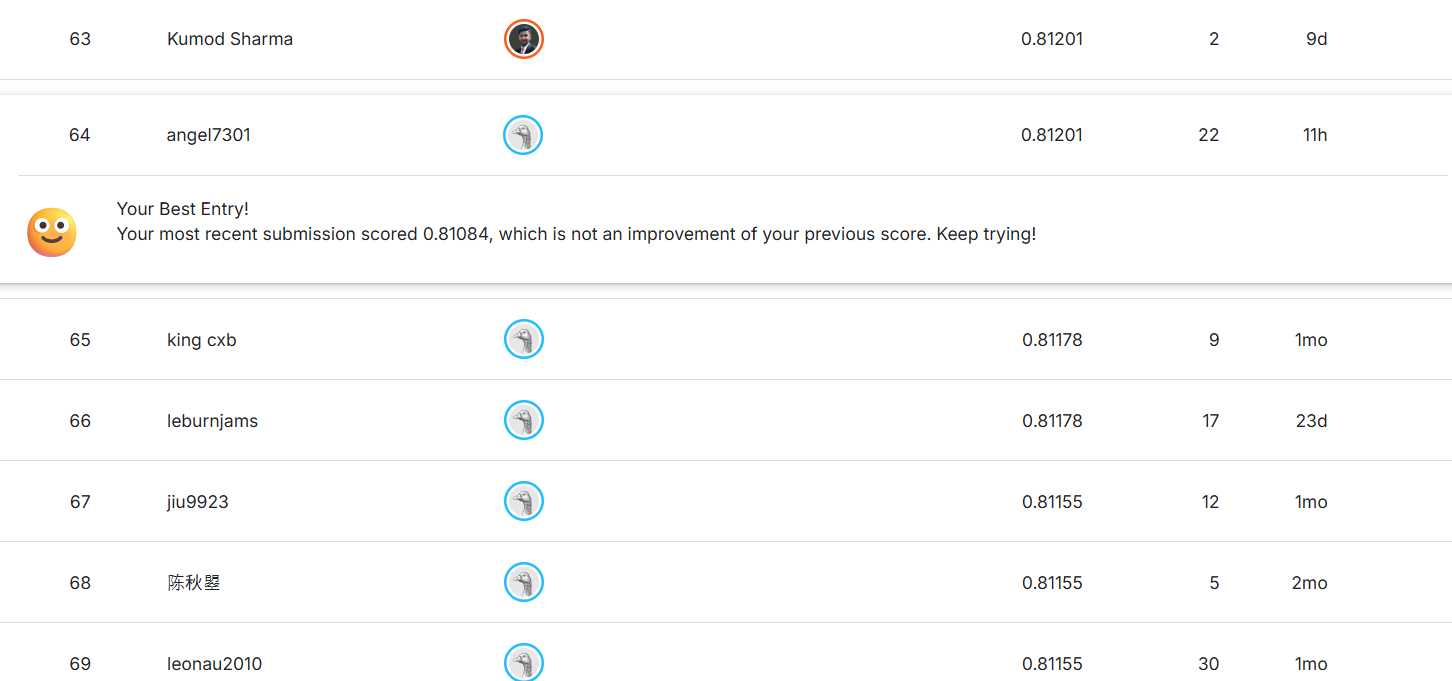